In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [535]:
import geopandas as gpd
import pandas as pd
# cities = gpd.read_file("zip:///Users/tsen6/Desktop/Python/tl_2019_24_tract.zip")

# cities['COUNTYFP'] = cities['COUNTYFP'].astype(str).astype(int)
# baltimore_counties = [510] #[163] #[87,93,99,125,147,163]

# baltimore = gpd.GeoDataFrame()
# for county in baltimore_counties:
#     #print(county)
#     temp = cities[cities['COUNTYFP']==county]
#     #print(temp)
#     baltimore = baltimore.append(temp)

In [536]:
# import pysal as ps
# dir(ps.explore)

In [537]:
# baltimore.to_file('tmp')
# ! rm -r tmp
# w = ps.rook_from_shapefile(, idVariable='NAMELSAD')
baltimore = gpd.read_file("baltimoe_data.shp")
baltimore.info()

w = ps.lib.weights.Queen.from_dataframe(baltimore)
baltimore = baltimore.drop(['pop_per_ar','county','state'],axis=1)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAMELSAD    200 non-null    object  
 1   ALAND       200 non-null    int64   
 2   INTPTLAT    200 non-null    object  
 3   INTPTLON    200 non-null    object  
 4   total_popu  200 non-null    object  
 5   median_age  200 non-null    object  
 6   Total hous  200 non-null    object  
 7   Occupied h  200 non-null    object  
 8   Vacant hou  200 non-null    object  
 9   Median roo  200 non-null    object  
 10  no vehicle  200 non-null    object  
 11  state       200 non-null    object  
 12  county      200 non-null    object  
 13  pop_per_ar  200 non-null    float64 
 14  pop_sq_mil  200 non-null    int64   
 15  geometry    200 non-null    geometry
dtypes: float64(1), geometry(1), int64(2), object(12)
memory usage: 25.1+ KB


In [538]:
np.random.seed(1234)
z = zrt.drop(['geometry', 'NAMELSAD'], axis=1).values

# maxp = ps.(w, z, thr, n_rev.values[:, None], initial=1000)
baltimore['total_popu'] = baltimore['total_popu'].astype(float)
baltimore['median_age'] = baltimore['median_age'].astype(float)
baltimore['aland_neg'] = -baltimore['ALAND']
baltimore['NAMELSAD']=baltimore['NAMELSAD'].astype(str)

gdf = baltimore

In [539]:
def cen_tract(tract_string):
    tract = float((tract_string.split()[2]))
    return tract
gdf['NAMELSAD'] = gdf.apply(lambda x: cen_tract(x['NAMELSAD']),axis=1)

In [540]:
df2018 = pd.read_csv('count2018.csv')
c = df2018.groupby(['Census_Tracts'])['Count'].sum()
dfTot2018 = pd.DataFrame(data = c)
dfTot2018['Census_Tracts']=dfTot2018.index
# gdf = gdf.drop(columns=['aland_neg'])
gdf = gdf.join(dfTot2018.set_index('Census_Tracts'), on='NAMELSAD')

In [541]:
def pop_911(df):
    rate = (df['Count']/(df['ALAND']+1))*100
    return rate
gdf['rate911'] = gdf.apply(lambda x: pop_911(x),axis=1)

In [574]:
dfDem = pd.read_csv('Demographics.csv')
dfDem.tract = dfDem.tract/100
gdf.NAMELSAD = gdf.NAMELSAD.astype(float)

In [748]:
New = gdf.drop(columns=['total_popu','median_age','Total hous','Occupied h','Median roo',
                       'no vehicle','aland_neg'])
New = New.join(dfDem.set_index('tract'), on='NAMELSAD')

In [793]:
New['% no vehicle available'] = New['no vehicle available']/New['total_population']
New['houses/area'] = New['Total housing units']/New['ALAND']*1000
New['%high school graduate'] = New['High School Graduate']/New['total_population']
New['Count_norm']=(New['Count']/(New['total_population']+1))
New['pop_sq_mil'] = New['pop_sq_mil']/10000
New['House Age'] = 2018 - New['Year Built']

New['Median Household Income'] = (New['Median Household Income']-
                                  New['Median Household Income'].min())/(New['Median Household Income'].max()-
                                                                         New['Median Household Income'].min())
New['houses/area'] = (New['houses/area']-
                      New['houses/area'].min())/(New['houses/area'].max()-
                                               New['houses/area'].min())
New['pop_sq_mil'] = (New['pop_sq_mil']-
                     New['pop_sq_mil'].min())/(New['pop_sq_mil'].max()-
                                          New['pop_sq_mil'].min())
New['House Age'] = (New['House Age']-
                    New['House Age'].min())/(New['House Age'].max()-
                                          New['House Age'].min())
New['Median rooms'] = (New['Median rooms']-
                      New['Median rooms'].min())/(New['Median rooms'].max()-
                                                  New['Median rooms'].min())
New.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   NAMELSAD                 200 non-null    object  
 1   ALAND                    200 non-null    int64   
 2   INTPTLAT                 200 non-null    object  
 3   INTPTLON                 200 non-null    object  
 4   Vacant hou               200 non-null    object  
 5   pop_sq_mil               200 non-null    float64 
 6   geometry                 200 non-null    geometry
 7   Count                    200 non-null    int64   
 8   rate911                  200 non-null    float64 
 9   Police District          200 non-null    object  
 10  Unnamed: 0               200 non-null    int64   
 11  total_population         200 non-null    int64   
 12  median_age               200 non-null    float64 
 13  High School Graduate     200 non-null    int64   
 14  Me

C:\Users\tsen6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 6 artists>

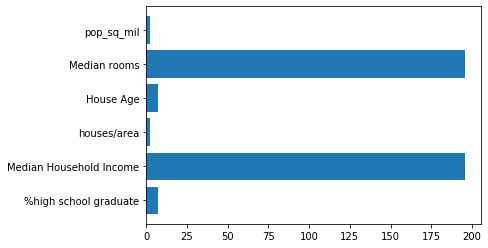

In [794]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

New['% no vehicle available'] = New['% no vehicle available'
                                   ].fillna(New['% no vehicle available'].min())
New['%high school graduate'] = New['%high school graduate'
                                  ].fillna(New['%high school graduate'].min())
New['Count_norm'] = New['Count_norm'
                                  ].fillna(New['Count_norm'].min())


X = New[['%high school graduate','Median Household Income',
         'houses/area','House Age',
         'Median rooms','pop_sq_mil']] #,'median_age'
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

y = New[['Count_norm']]
scaler = MinMaxScaler()
scaler.fit(y)
y = scaler.transform(y)

labels = ['%high school graduate','Median Household Income',
         'houses/area','House Age',
         'Median rooms','pop_sq_mil']#,'median_age']
# print(X[51:80])
# define feature selection
fs = SelectKBest(score_func=f_regression, k=5)
# apply feature selection
X_selected = fs.fit_transform(X, y)
# print(X_selected.shape)
plt.barh(labels,fs.scores_)

In [861]:
import numpy as np
zrt = New
zrt['NAMELSAD'] = zrt['NAMELSAD'].astype(str)
# gdf['total_popu']=gdf['total_popu'].astype(float)
n_rev = zrt.groupby('NAMELSAD')\
           .sum()\
           ['Count']\
           .rename(lambda x: str((x)))\
           .reindex(zrt['NAMELSAD'])

thr = np.round(0.095 * n_rev.sum())
thr
# baltimore.NAMELSAD

59023.0

In [866]:
import scipy
from region.max_p_regions.heuristics import MaxPRegionsHeu
import pysal as ps
from region.p_regions.azp import *
from libpysal.weights import Queen, Rook

Fin = New

w_queen = Queen.from_dataframe(Fin)
w_rook = Rook.from_dataframe(Fin)

adj = scipy.sparse.csr_matrix(w_rook.full()[0])

values_gdf = Fin[['Median Household Income']] #,
#                   'House Age', 
#                   'pop_sq_mil','houses/area']]
spatially_extensive_attr_gdf = Fin[['Count']].values #'total_popu',

i = 100
threshold = [thr]
model = MaxPRegionsHeu(local_search = AZP(), random_state=i)
model.fit_from_w(w_rook, values_gdf.values, spatially_extensive_attr_gdf, threshold = threshold)
Fin['labels'] = model.labels_

# MaxPRegionsHeu.fit_from_geodataframe(w, z, thr, n_rev.values[:, None], initial=1000)
# dir(region.max_p_regions)
# # maxp = region.Maxp(w, z, thr, n_rev.values[:, None], initial=1000)

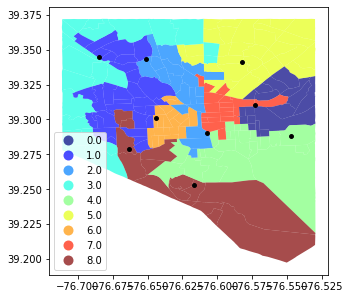

In [867]:
Fin['labels']=Fin['labels'].astype(str)
base = Fin.plot(cmap = 'jet',figsize=[5,5],column = 'labels', legend=True, alpha=0.7)
# base.legend(loc='upper left')
Stations = pd.read_csv('Police_Stations.csv')
Stations = gpd.GeoDataFrame(
    Stations, geometry=gpd.points_from_xy(Stations.longitude, Stations.latitude))
Stations.plot(ax=base, marker='o', color='black', markersize=15);

Avergae Deviation from mean = 22739.0
# Zones = 9
Maximum Load = 82559


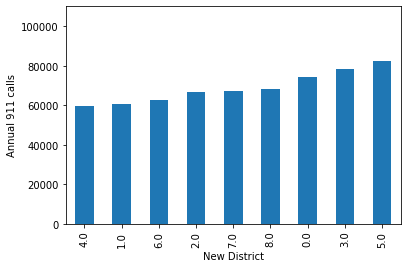

In [864]:
c = Fin.groupby(['labels'])['Count'].sum().sort_values()
ax = c.plot.bar()
ax.set_xlabel('New District')
ax.set_ylabel('Annual 911 calls')
ax.set_ylim(0, 110000)
print('Avergae Deviation from mean =' , round(np.mean(abs(c.values.max()
                                                          - c.values.min()))))
print('# Zones =', len(c))
print('Maximum Load =' , c.values.max())

In [865]:
dfUsed = Fin
ctracts = dfUsed.NAMELSAD.unique()
New_dist = []
for ct in ctracts:
    for idx in dfUsed.index:
        if dfUsed.NAMELSAD[idx]==ct:
            New_dist.append(dfUsed.labels[idx])
            break

d = {'New_district': New_dist, 'census_tracts': dfUsed.NAMELSAD.unique()}
ND_tract = pd.DataFrame(data=d)

ND_tract.sort_values(by=['New_district'])
ND_tract.to_csv('Tract_ND.csv',index=False)

In [600]:
PD_tract = pd.read_csv('Tract_PD.csv')
PD = []
for idx in gdf.index:
    ct = gdf.NAMELSAD[idx]
    xx = (PD_tract[PD_tract['census_tracts']==float(ct)].Police_district.values[0])
    PD.append(xx)
    
gdf['Police District']=PD

Avergae Deviation from mean = 46997.0
# Zones = 9
Maximum Load = 100401


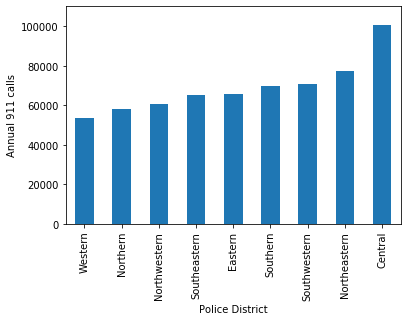

In [737]:
c = gdf.groupby(['Police District'])['Count'].sum().sort_values()
ax = c.plot.bar()
ax.set_xlabel('Police District')
ax.set_ylabel('Annual 911 calls')
ax.set_ylim(0, 110000)
print('Avergae Deviation from mean =' , round(np.mean(abs(c.values.max()
                                                          - c.values.min()))))
print('# Zones =', len(c))
print('Maximum Load =' , c.values.max())

In [745]:
Area = Fin.groupby(['labels'])['ALAND'].sum()
Area

labels
0.0    16963737
1.0    18232181
2.0    15620426
3.0    27274346
4.0    21832356
5.0    28957907
6.0    10722178
7.0    31313509
8.0    38734330
Name: ALAND, dtype: int64

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())